# Train an autoencoder on the Textile dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

from train import train
from models import Autoencoder_one_layer_SPDnet, Autoencoder_nlayers_regular_SPDnet
from spdnet.loss import RiemannianDistanceLoss
from data_preprocessing import LabeledDataset

from skimage import filters
import h5py
import pandas as pd

from pyriemann.classification import MDM

from tqdm.notebook import tqdm
import plotly.graph_objects as go

## Load dataset

In [2]:
filename = "../data/textile/train64.h5"
f = h5py.File(filename, "r")
my_data = pd.read_csv("../data/textile/train64.csv", delimiter=",")

labels = my_data["indication_type"]
cool = f["images"]
ind = np.where((labels == "good") | (labels == "cut"))
coo = cool[ind[0], :, :, 0]
lab = labels[ind[0]]

Vals = []
Covs = []
imgs = []

for i in tqdm(range(len(ind[0]))):

    # We normalize the images to prevent any bias based on lighting or intensity
    # prior to filtering and covariance matrix computation.
    g = (coo[i, 1:, 1:] - np.mean(coo[i, 1:, 1:])) / np.std(coo[i, 1:, 1:])
    Intensity = g.flatten()
    Xdif = np.diff(g, axis=0)
    Ydif = np.diff(g, axis=1)
    Xdiff = np.diff(g, axis=0).flatten()
    Ydiff = np.diff(g, axis=1).flatten()
    gauss = filters.gaussian(g, sigma=2)
    gauss1 = filters.gaussian(g, sigma=3)
    gauss2 = filters.gaussian(g, sigma=4)
    gaus = filters.gaussian(g, sigma=2).flatten()
    gaus1 = filters.gaussian(g, sigma=3).flatten()
    gaus2 = filters.gaussian(g, sigma=4).flatten()
    hess = filters.laplace(g).flatten()
    frang = filters.farid(g).flatten()
    hess1 = filters.laplace(gauss).flatten()
    frang1 = filters.farid(gauss).flatten()
    hess2 = filters.laplace(gauss1).flatten()
    frang2 = filters.farid(gauss1).flatten()

    imgs.append(Intensity)

    Val = np.vstack(
        [Intensity, gaus, gaus1, gaus2, hess, frang, hess1, hess2, frang1, frang2]
    )

    Vals.append(Val)

    Covs.append(np.cov(Val))
all_cov = np.array(Covs)
all_labels = np.array(lab)
N, size_matrices, _ = all_cov.shape
print(all_cov.shape)

  0%|          | 0/16000 [00:00<?, ?it/s]

(16000, 10, 10)


In [3]:
all_cov_torch = torch.from_numpy(all_cov).unsqueeze(1)
dataset_textile = LabeledDataset(all_cov_torch, all_labels)

In [4]:
batch_size = 32
x_train, x_val, x_test = torch.utils.data.random_split(
    dataset_textile, lengths=[0.5, 0.25, 0.25]
)

train_loader = torch.utils.data.DataLoader(
    x_train, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    x_val, batch_size=batch_size * 2, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    x_test, batch_size=batch_size, shuffle=False
)

In [5]:
hi = 1 # Number of channels input
ho = 1 # Number of channels output
ni = size_matrices # Dimension of matrices input
no = 4 # Dimension of matrices output
n_layers = 3

In [6]:
model = Autoencoder_nlayers_regular_SPDnet(ho, hi, ni, no, n_layers)

In [7]:
model

Autoencoder_nlayers_regular_SPDnet(
  (encoder): Sequential(
    (0): BiMap()
    (1): ReEig()
    (2): BiMap()
    (3): ReEig()
    (4): LogEig()
  )
  (decoder): Sequential(
    (0): ExpEig()
    (1): ReEig()
    (2): BiMap()
    (3): ReEig()
    (4): BiMap()
    (5): ReEig()
  )
)

In [8]:
criterion = RiemannianDistanceLoss()
n_epochs = 100
lr = 0.001

In [9]:
res = train(train_loader, val_loader, model, n_epochs, criterion, lr=lr)

Training: 100%|██████████| 100/100 [05:02<00:00,  3.03s/it, Train Loss=0.0886, Val Loss=0.045]


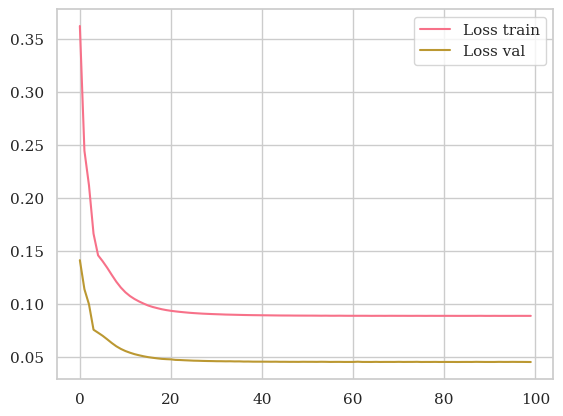

In [29]:
fig = plt.figure()
plt.plot(res[2], label="Loss train")
plt.plot(res[-1], label="Loss val")
plt.legend()
fig = tikzplotlib_fix_ncols(fig)
#tikzplotlib.save("test.tex")

--- 
## Train an MDM in the code space


In [17]:
from pyriemann.classification import MDM
from sklearn.model_selection import train_test_split

In [18]:
cov_test = x_test.dataset[x_test.indices][0].detach().numpy()[:,0]
labels_test = x_test.dataset[x_test.indices][1]

In [34]:
train_MDM, test_MDM, label_train_MDM, label_test_MDM = train_test_split(cov_test,labels_test, test_size=0.2, shuffle=True,random_state=42)

In [35]:
MDM_hd = MDM()
MDM_hd.fit(train_MDM, label_train_MDM)
MDM_hd.score(test_MDM, label_test_MDM)

0.84

In [36]:
model.eval()
with torch.no_grad():
    train_MDM_after_AE = model(torch.from_numpy(train_MDM).unsqueeze(1))
    test_MDM_after_AE = model(torch.from_numpy(test_MDM).unsqueeze(1))

In [37]:
MDM_after_AE = MDM()
MDM_after_AE.fit(train_MDM_after_AE.detach().numpy()[:,0], label_train_MDM)
MDM_after_AE.score(test_MDM_after_AE.detach().numpy()[:,0], label_test_MDM)

0.8475